In [29]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Custom modules
import sys
sys.path.append('../src')

from data.preprocessing import load_processed_data, load_transformers
from models.train import (
    cross_validate_models,
    evaluate_on_test,
    save_model,
    get_best_model
)
from models.evaluate import (
    plot_confusion_matrix,
    plot_model_comparison,
    plot_feature_importance,
    plot_cv_results,
    print_model_summary
)

# Utilities
import os
import joblib
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


In [4]:
print("="*70)
print("LOADING PREPROCESSED DATA")
print("="*70)

# Load data
data = load_processed_data()
scaler, encoder = load_transformers()

# Extract arrays 
X_train = data['X_train'].values
X_val = data['X_val'].values
X_test = data['X_test'].values

y_train = data['y_train'].values
y_val = data['y_val'].values
y_test = data['y_test'].values

#combine train + val for hyper parameter search 
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.vstack([y_train, y_val])

print(f"\n✅ Data loaded successfully:")
print(f"   Train + Val: {X_train_full.shape}")
print(f"   Test:        {X_test.shape}")
print(f"   Features:    {data['X_train'].columns.tolist()}")
print(f"   Classes:     {len(encoder.classes_)}")

# Store for later use
feature_names = data['X_train'].columns.tolist()
class_names = encoder.classes_

LOADING PREPROCESSED DATA
✅ Loaded X_train: (1540, 7)
✅ Loaded X_val: (330, 7)
✅ Loaded X_test: (330, 7)
✅ Loaded y_train: (1540, 1)
✅ Loaded y_val: (330, 1)
✅ Loaded y_test: (330, 1)

✅ Loaded transformers:

✅ Data loaded successfully:
   Train + Val: (1870, 7)
   Test:        (330, 7)
   Features:    ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
   Classes:     22


In [5]:
print("="*70)
print("DEFINING HYPERPARAMETER SEARCH SPACES")
print("="*70)

# Based on your baseline results, tune only the top 3 models
# Adjust based on what performed best in notebook 03

param_grids = {
    
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },
    
    'XGBoost': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.5],
        'min_child_weight': [1, 3, 5, 7],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    
    'SVM': {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4, 5],          # only for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5, 1.0],    # for 'poly' and 'sigmoid'
    'class_weight': [None, 'balanced'],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5]
    }
}

# Calculate search space sizes
print("\nSearch Space Sizes:")
print("-" * 70)
for model_name, params in param_grids.items():
    total_combinations = np.prod([len(v) for v in params.values()])
    print(f"{model_name:20s}: {total_combinations:,d} combinations")

print("\n💡 Using RandomizedSearchCV for efficient search")

DEFINING HYPERPARAMETER SEARCH SPACES

Search Space Sizes:
----------------------------------------------------------------------
Random Forest       : 1,152 combinations
XGBoost             : 138,240 combinations
SVM                 : 23,040 combinations

💡 Using RandomizedSearchCV for efficient search


In [8]:
def tune_model(
    model_class, model_name, param_grid, X_train, y_train,
    search_type = "random", n_iter = 50, cv = 5
):
    print("="*70)
    print(f"TUNING: {model_name}")
    print("="*70)

    # Initialize base model 
    if model_name == 'Random Forest':
        base_model = model_class(
            random_state = 42, n_jobs = -1
        )
    elif model_name == 'XGBoost': 
        base_model = model_class(
            random_state = 42, n_jobs = -1, eval_metric = 'mlogloss'
        )
    elif model_name == 'SVM': 
        base_model = model_class(
            probability = True, random_state = 42
        )
    else: 
        base_model = model_class()

    # CHoose search method 
    if search_type == 'random':
        search = RandomizedSearchCV(
            estimator= base_model, 
            param_distributions = param_grid,
            n_iter = n_iter, 
            cv = cv, 
            scoring= 'accuracy', 
            random_state= 42, 
            verbose= 2
        )
    else: 
        search = GridSearchCV(
            estimator = base_model, 
            param_grid = param_grid,
            cv = cv, 
            scoring = 'accuracy',
            n_jobs = -1, 
            verbose = 2
        )

    # Perform search 
    print(f"\n🔍 Starting {search_type} search with {cv}-fold CV...")
    start_time = time.time()

    search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time 

    # Results
    print(f"\n✅ Search completed in {elapsed_time/60:.2f} minutes")
    print(f"\n🏆 Best Cross-Validation Score: {search.best_score_:.4f}")
    print(f"\n📋 Best Hyperparameters:")
    for param, value in search.best_params_.items():
        print(f"   {param:25s}: {value}")
    
    return {
        'model': search.best_estimator_,
        'best_params': search.best_params_,
        'best_cv_score': search.best_score_,
        'cv_results': search.cv_results_,
        'search_object': search
    }

print("✅ Tuning function defined")

✅ Tuning function defined


In [9]:
rf_results = tune_model(
    model_class=RandomForestClassifier,
    model_name='Random Forest',
    param_grid=param_grids['Random Forest'],
    X_train=X_train_full,
    y_train=y_train_full,
    search_type='random',
    n_iter=50,
    cv=5
)

# Quick validation on test set
rf_test_pred = rf_results['model'].predict(X_test)
rf_test_acc = (rf_test_pred == y_test).mean()

print(f"\n📊 Test Set Preview: {rf_test_acc:.4f}")

TUNING: Random Forest

🔍 Starting random search with 5-fold CV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split

In [10]:
xgb_results = tune_model(
    model_class=XGBClassifier,
    model_name='XGBoost',
    param_grid=param_grids['XGBoost'],
    X_train=X_train_full,
    y_train=y_train_full,
    search_type='random',
    n_iter=50,
    cv=5
)

# Quick validation on test set
xgb_test_pred = xgb_results['model'].predict(X_test)
xgb_test_acc = (xgb_test_pred == y_test).mean()

print(f"\n📊 Test Set Preview: {xgb_test_acc:.4f}")

TUNING: XGBoost

🔍 Starting random search with 5-fold CV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=500, reg_alpha=0.5, reg_lambda=2, subsample=1.0; total time=   3.8s
[CV

In [13]:
svm_results = tune_model(
    model_class= SVC,
    model_name='SVM',
    param_grid=param_grids['SVM'],
    X_train=X_train_full,
    y_train=y_train_full,
    search_type='random',
    n_iter=30,  # Smaller search space
    cv=5
)

# Quick validation on test set
svm_test_pred = svm_results['model'].predict(X_test)
svm_test_acc = (svm_test_pred == y_test).mean()

print(f"\n📊 Test Set Preview: {svm_test_acc:.4f}")

TUNING: SVM

🔍 Starting random search with 5-fold CV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END C=10, class_weight=None, coef0=1.0, degree=3, gamma=0.1, kernel=linear, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=10, class_weight=None, coef0=1.0, degree=3, gamma=0.1, kernel=linear, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=10, class_weight=None, coef0=1.0, degree=3, gamma=0.1, kernel=linear, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=10, class_weight=None, coef0=1.0, degree=3, gamma=0.1, kernel=linear, shrinking=False, tol=0.001; total time=   0.3s
[CV] END C=10, class_weight=None, coef0=1.0, degree=3, gamma=0.1, kernel=linear, shrinking=False, tol=0.001; total time=   0.4s
[CV] END C=0.01, class_weight=None, coef0=0.1, degree=3, gamma=1, kernel=sigmoid, shrinking=True, tol=1e-05; total time=   5.8s
[CV] END C=0.01, class_weight=None, coef0=0.1, degree=3, gamma=1, kernel=sigmoid, shrinking=True, tol=1e-05; total

COMPARING TUNED MODELS
TEST SET EVALUATION

✅ Test Set Performance:
   Accuracy:  0.9939
   F1-Score:  0.9939
   Precision: 0.9943
   Recall:    0.9939

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
   blackgram       1.00      0.93      0.97        15
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
      grapes       1.00      1.00      1.00        15
        jute       0.94      1.00      0.97        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      1.00      1.00        15
       maize       0.94      1.00      0.97        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00        15
    mungbean 

,Model,CV Score,Test Accuracy,Test F1-Score,Test Precision,Test Recall
1,XGBoost,0.996257,0.996970,0.996966,0.997159,0.996970
0,Random Forest,0.995187,0.993939,0.993933,0.994318,0.993939
2,SVM,0.986631,0.990909,0.990899,0.991477,0.990909


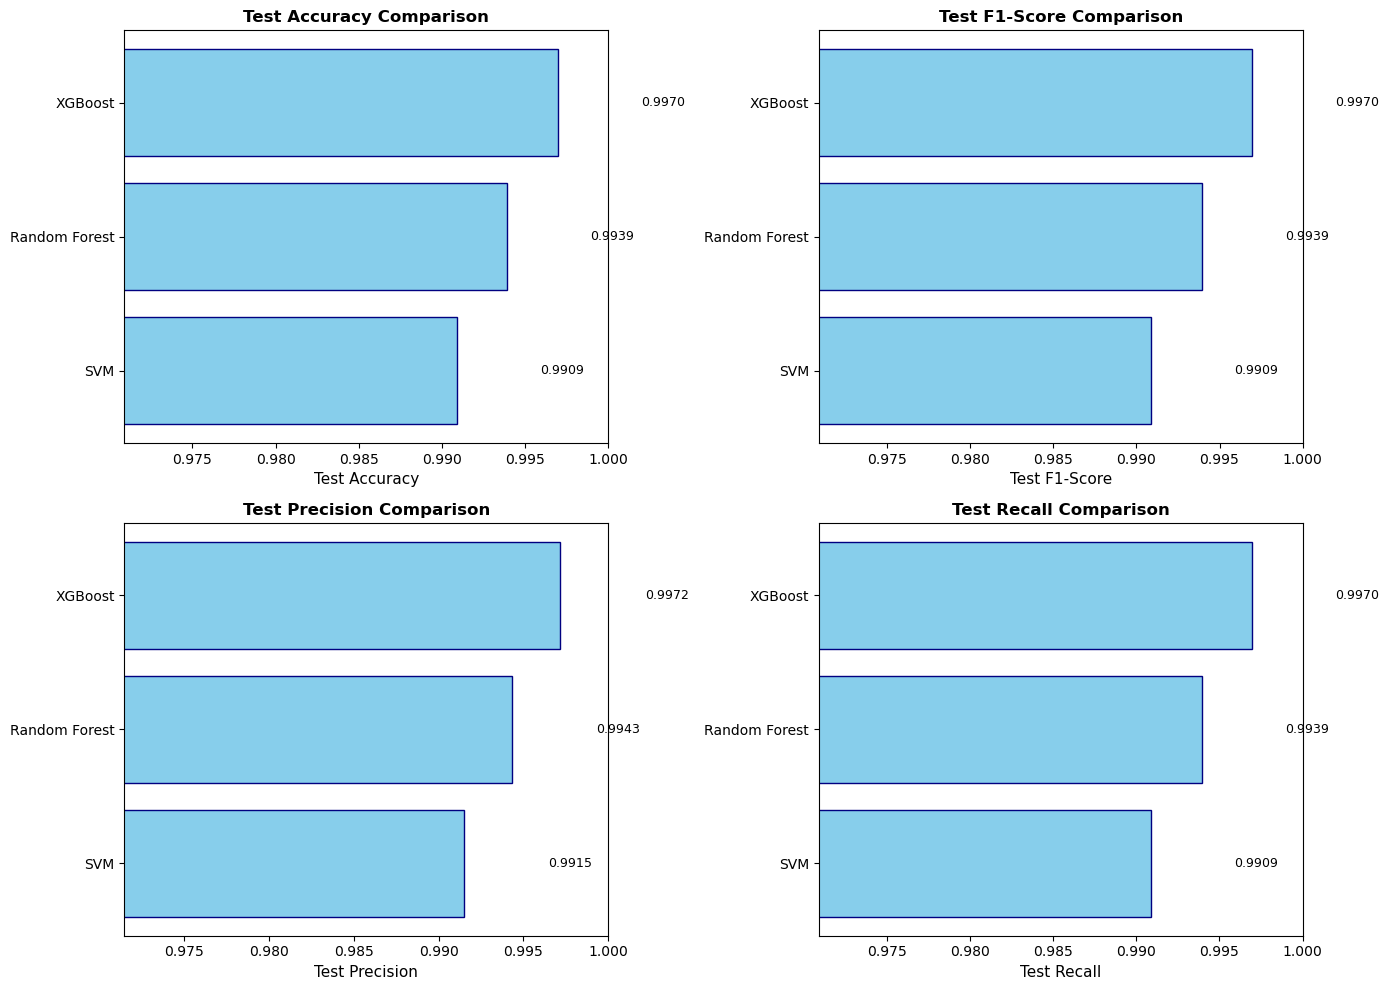

In [16]:
print("="*70)
print("COMPARING TUNED MODELS")
print("="*70)

# Compile results 
tuned_models = {
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'SVM': svm_results
}

# Create comparison dataframe 
comparison_data = [] 

for model_name, results in tuned_models.items(): 
    # Evaluate on test set properly 
    test_results = evaluate_on_test(
        results['model'], 
        X_test, y_test, 
        class_names = class_names
    )

    comparison_data.append({
        'Model': model_name,
        'CV Score': results['best_cv_score'],
        'Test Accuracy': test_results['metrics']['accuracy'],
        'Test F1-Score': test_results['metrics']['f1_score'],
        'Test Precision': test_results['metrics']['precision'],
        'Test Recall': test_results['metrics']['recall'] 
    })

    # Store test results
    tuned_models[model_name]['test_results'] = test_results 

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending = False)

print("\n📊 Model Comparison:")
display(comparison_df.style.highlight_max(
    subset=['CV Score', 'Test Accuracy', 'Test F1-Score'],
    color='green'
))

# Visualize comparison
plot_model_comparison(
    comparison_df,
    metrics=['Test Accuracy', 'Test F1-Score', 'Test Precision', 'Test Recall']
)

In [17]:
# Get best model
best_model_name = comparison_df.iloc[0]['Model']
best_results = tuned_models[best_model_name]
best_model = best_results['model']

print("="*70)
print(f"BEST MODEL: {best_model_name}")
print("="*70)

# Print summary
print_model_summary(
    model_name=best_model_name,
    train_metrics={'cv_score': best_results['best_cv_score']},
    val_metrics={'cv_score': best_results['best_cv_score']},
    test_metrics=best_results['test_results']['metrics']
)

# Best hyperparameters
print("\n🎯 Optimal Hyperparameters:")
print("-" * 70)
for param, value in best_results['best_params'].items():
    print(f"   {param:25s}: {value}")

BEST MODEL: XGBoost
MODEL SUMMARY: XGBoost

📊 Training Performance:
   Cv Score    : 0.9963

📊 Validation Performance:
   Cv Score    : 0.9963

📊 Test Performance:
   Accuracy    : 0.9970
   F1 Score    : 0.9970
   Precision   : 0.9972
   Recall      : 0.9970

🎯 Optimal Hyperparameters:
----------------------------------------------------------------------
   subsample                : 1.0
   reg_lambda               : 2
   reg_alpha                : 0.5
   n_estimators             : 500
   min_child_weight         : 1
   max_depth                : 7
   learning_rate            : 0.1
   gamma                    : 0.5
   colsample_bytree         : 0.6


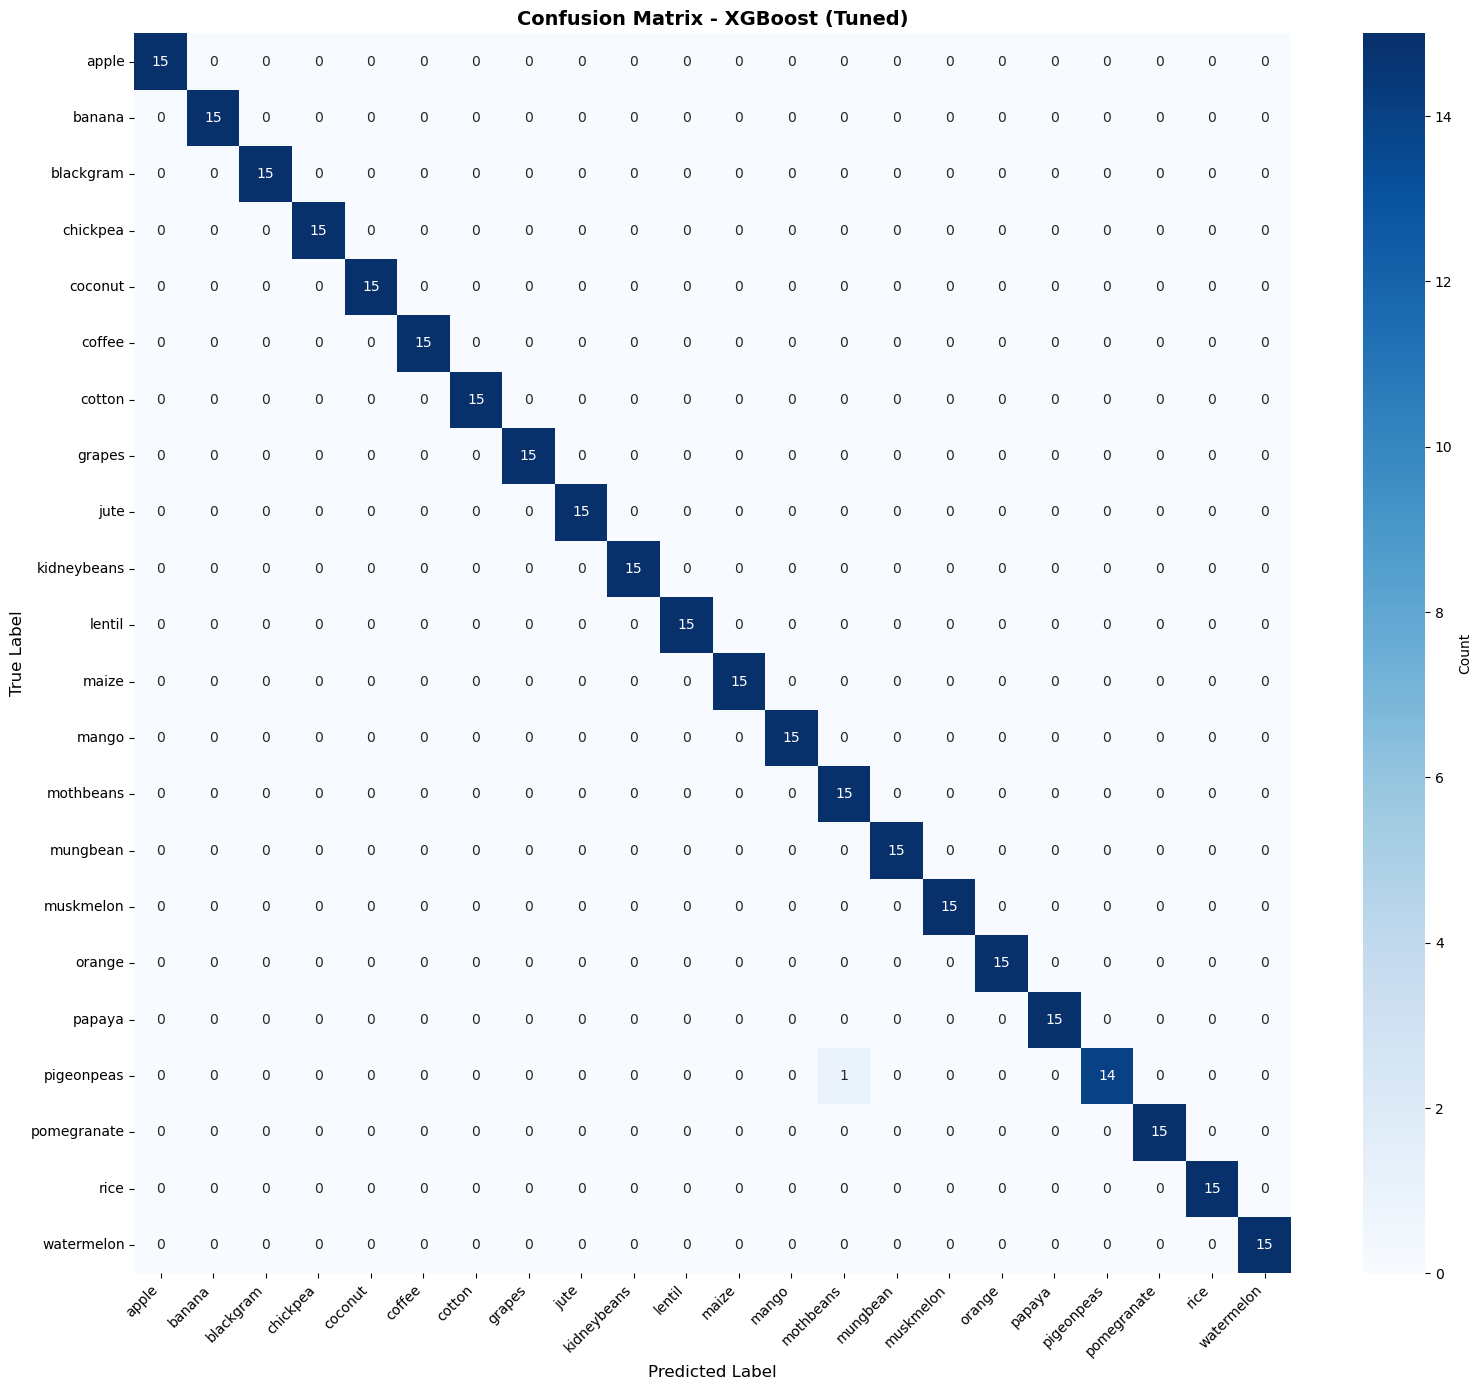


📊 Per-Class Accuracy:
----------------------------------------------------------------------
apple               : 1.0000
banana              : 1.0000
blackgram           : 1.0000
chickpea            : 1.0000
coconut             : 1.0000
coffee              : 1.0000
cotton              : 1.0000
grapes              : 1.0000
jute                : 1.0000
kidneybeans         : 1.0000
lentil              : 1.0000
maize               : 1.0000
mango               : 1.0000
mothbeans           : 1.0000
mungbean            : 1.0000
muskmelon           : 1.0000
orange              : 1.0000
papaya              : 1.0000
pigeonpeas          : 0.9333
pomegranate         : 1.0000
rice                : 1.0000
watermelon          : 1.0000


In [18]:
# Plot confusion matrix for best model
test_results = best_results['test_results']

plot_confusion_matrix(
    y_true=y_test,
    y_pred=test_results['predictions'],
    class_names=class_names,
    title=f'Confusion Matrix - {best_model_name} (Tuned)',
    figsize=(16, 14)
)

# Per-class accuracy
print("\n📊 Per-Class Accuracy:")
print("-" * 70)
cm = test_results['confusion_matrix']
class_accuracies = cm.diagonal() / cm.sum(axis=1)

for crop, acc in zip(class_names, class_accuracies):
    print(f"{crop:20s}: {acc:.4f}")

FEATURE IMPORTANCE ANALYSIS


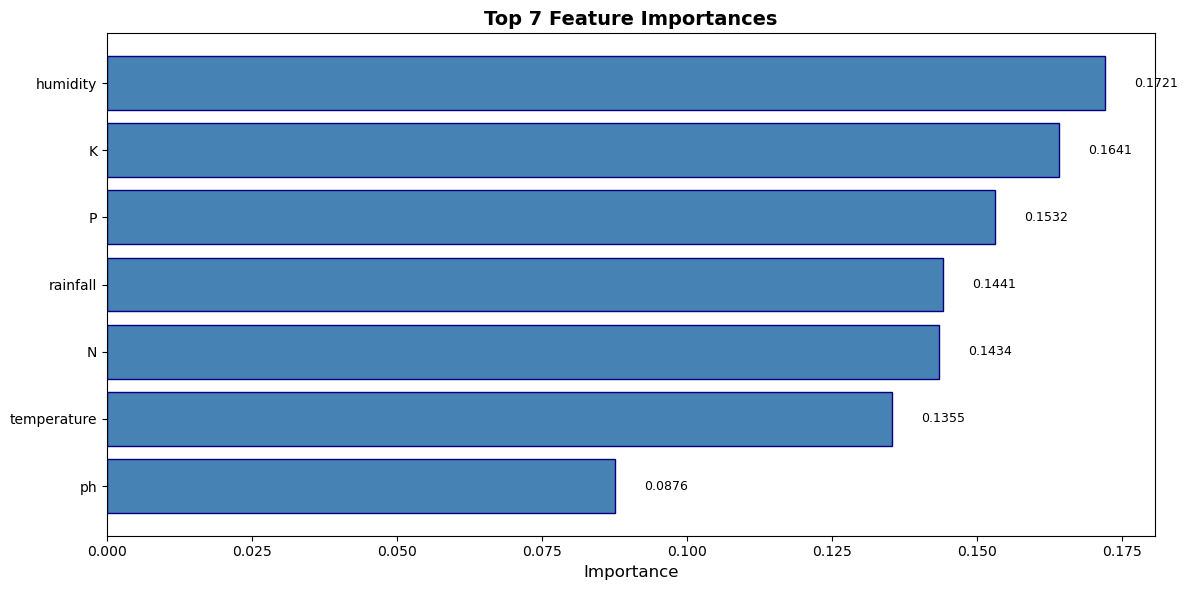


All Feature Importances:


,Feature,Importance
4,humidity,0.172062
2,K,0.164139
1,P,0.153150
6,rainfall,0.144124
0,N,0.143446
3,temperature,0.135455
5,ph,0.087624


In [23]:
# Plot feature importance
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

plot_feature_importance(
    model=best_model,
    feature_names=feature_names,
    top_n=7,
    figsize=(12, 6)
)

# Print all importances
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nAll Feature Importances:")
    display(importance_df)

In [24]:
# Analyze CV results for best model
print("="*70)
print("CROSS-VALIDATION ANALYSIS")
print("="*70)

cv_results = best_results['cv_results']

# Extract mean and std scores
cv_scores_mean = cv_results['mean_test_score']
cv_scores_std = cv_results['std_test_score']

# Get top 10 configurations
top_indices = np.argsort(cv_scores_mean)[-10:][::-1]

print("\n🏆 Top 10 Configurations:")
print("-" * 70)

for rank, idx in enumerate(top_indices, 1):
    print(f"\nRank {rank}:")
    print(f"   CV Score: {cv_scores_mean[idx]:.4f} (+/- {cv_scores_std[idx]:.4f})")
    print(f"   Params: {cv_results['params'][idx]}")

CROSS-VALIDATION ANALYSIS

🏆 Top 10 Configurations:
----------------------------------------------------------------------

Rank 1:
   CV Score: 0.9963 (+/- 0.0013)
   Params: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}

Rank 2:
   CV Score: 0.9957 (+/- 0.0027)
   Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}

Rank 3:
   CV Score: 0.9952 (+/- 0.0020)
   Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

Rank 4:
   CV Score: 0.9947 (+/- 0.0034)
   Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.2,

In [25]:
print("="*70)
print("MODEL STABILITY CHECK")
print("="*70)

# Compare CV score vs Test score
cv_score = best_results['best_cv_score']
test_score = best_results['test_results']['metrics']['accuracy']
difference = abs(cv_score - test_score)

print(f"\n📊 Score Comparison:")
print(f"   Best CV Score:   {cv_score:.4f}")
print(f"   Test Accuracy:   {test_score:.4f}")
print(f"   Difference:      {difference:.4f} ({difference*100:.2f}%)")

if difference < 0.01:
    print("\n✅ Excellent! Model is very stable (< 1% difference)")
elif difference < 0.02:
    print("\n✅ Good! Model generalizes well (< 2% difference)")
elif difference < 0.03:
    print("\n⚠️  Acceptable stability (< 3% difference)")
else:
    print("\n❌ Warning! Possible overfitting (> 3% difference)")
    print("   Consider: More regularization, more data, or simpler model")

MODEL STABILITY CHECK

📊 Score Comparison:
   Best CV Score:   0.9963
   Test Accuracy:   0.9970
   Difference:      0.0007 (0.07%)

✅ Excellent! Model is very stable (< 1% difference)


In [27]:
print("="*70)
print("BASELINE vs TUNED COMPARISON")
print("="*70)

baseline_results = {
    'Random Forest': 0.9969,  
    'XGBoost': 0.9909,        
    'SVM': 0.9909            
}

print("\n📊 Performance Improvement:")
print("-" * 70)

for model_name in tuned_models.keys():
    if model_name in baseline_results:
        baseline_acc = baseline_results[model_name]
        tuned_acc = tuned_models[model_name]['test_results']['metrics']['accuracy']
        improvement = tuned_acc - baseline_acc
        
        print(f"\n{model_name}:")
        print(f"   Baseline:    {baseline_acc:.4f}")
        print(f"   Tuned:       {tuned_acc:.4f}")
        print(f"   Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")

BASELINE vs TUNED COMPARISON

📊 Performance Improvement:
----------------------------------------------------------------------

Random Forest:
   Baseline:    0.9969
   Tuned:       0.9939
   Improvement: -0.0030 (-0.30%)

XGBoost:
   Baseline:    0.9909
   Tuned:       0.9970
   Improvement: +0.0061 (+0.61%)

SVM:
   Baseline:    0.9909
   Tuned:       0.9909
   Improvement: +0.0000 (+0.00%)


In [33]:
print("="*70)
print("SAVING FINAL MODEL")
print("="*70)

# Prepare metadata
metadata = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'best_params': best_results['best_params'],
    'cv_score': best_results['best_cv_score'],
    'test_metrics': best_results['test_results']['metrics'],
    'num_classes': len(class_names),
    'classes': class_names.tolist(),
    'feature_names': feature_names,
    'training_samples': len(X_train_full),
    'test_samples': len(X_test)
}

# Save using our custom function
model_path = save_model(
    model=best_model,
    model_name=f"final_{best_model_name}",
    metrics=best_results['test_results']['metrics'],
    save_dir='../models',
    metadata=metadata
)

print("\n✅ Model and metadata saved successfully!")
print(f"\n📁 Files saved in: ../models/")
print(f"   - Model file: {os.path.basename(model_path)}")
print(f"   - Metadata file: final_{best_model_name.lower().replace(' ', '_')}_metadata_*.json")

SAVING FINAL MODEL

✅ Model saved:
   Model:    ../models\final_xgboost_20260117_220957.pkl
   Metadata: ../models\final_xgboost_metadata_20260117_220957.json

✅ Model and metadata saved successfully!

📁 Files saved in: ../models/
   - Model file: final_xgboost_20260117_220957.pkl
   - Metadata file: final_xgboost_metadata_*.json


In [32]:
print("="*70)
print("🎉 HYPERPARAMETER TUNING COMPLETE!")
print("="*70)

print(f"\n🏆 Final Production Model:")
print(f"   Model:         {best_model_name}")
print(f"   CV Score:      {best_results['best_cv_score']:.4f}")
print(f"   Test Accuracy: {best_results['test_results']['metrics']['accuracy']:.4f}")
print(f"   Test F1-Score: {best_results['test_results']['metrics']['f1_score']:.4f}")

print(f"\n📊 Model Performance:")
for metric, value in best_results['test_results']['metrics'].items():
    print(f"   {metric.replace('_', ' ').title():15s}: {value:.4f}")

print(f"\n💾 Model saved and ready for deployment!")
print(f"\n📝 Next Steps:")
print("   1. ✅ Model trained and tuned")
print("   2. ✅ Performance validated")
print("   3. ✅ Model saved")
print("   4. ⏭️ Create deployment/inference script")
print("   5. ⏭️ (Optional) Create simple web interface")

print("\n" + "="*70)

🎉 HYPERPARAMETER TUNING COMPLETE!

🏆 Final Production Model:
   Model:         XGBoost
   CV Score:      0.9963
   Test Accuracy: 0.9970
   Test F1-Score: 0.9970

📊 Model Performance:
   Accuracy       : 0.9970
   F1 Score       : 0.9970
   Precision      : 0.9972
   Recall         : 0.9970

💾 Model saved and ready for deployment!

📝 Next Steps:
   1. ✅ Model trained and tuned
   2. ✅ Performance validated
   3. ✅ Model saved
   4. ⏭️ Create deployment/inference script
   5. ⏭️ (Optional) Create simple web interface

